<a href="https://colab.research.google.com/github/Sneha-Sonkar/Airfare-Regression-Analysis/blob/main/Copy_of_Airfare_Price_Prediction_Model_by_CatBoost%7CR2_0_91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive and import the Excel file
from google.colab import drive
import pandas as pd

# Install openpyxl in case it's not already available
!pip install -q openpyxl

# Mount the drive
drive.mount('/content/drive')

# Read the Excel file from Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Data_Train.xlsx'
df = pd.read_excel(file_path)

# Display the first 5 rows
df.head()


Mounted at /content/drive


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# Importing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install -q catboost
!pip install -q shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import time


import catboost as cb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Data Outline

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


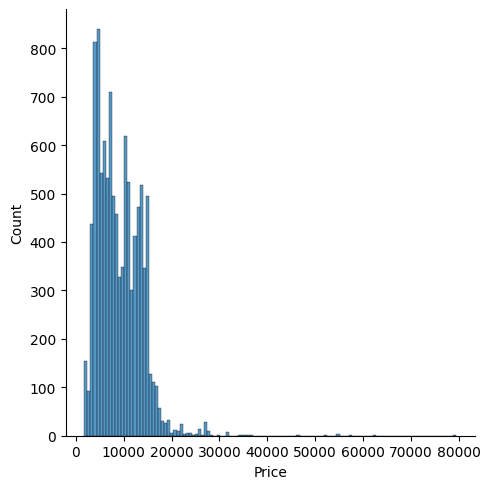

In [ ]:
sns.displot(x= 'Price', data=df);

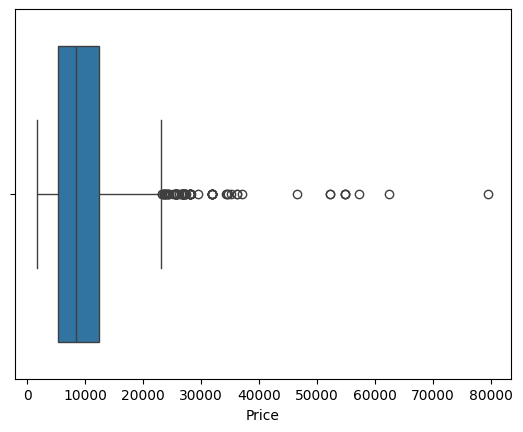

In [ ]:
sns.boxplot(x= 'Price', data=df);

**There are some outliers.**

# Features Engineering

**Drop price 30,000 or more.**

In [ ]:
df=df.query('Price <= 30000')

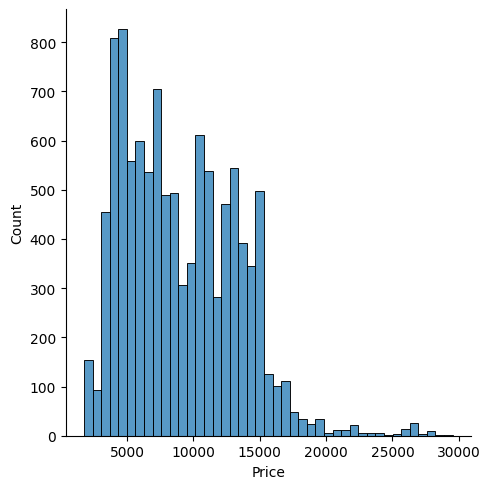

In [ ]:
sns.displot(x= 'Price', data=df);

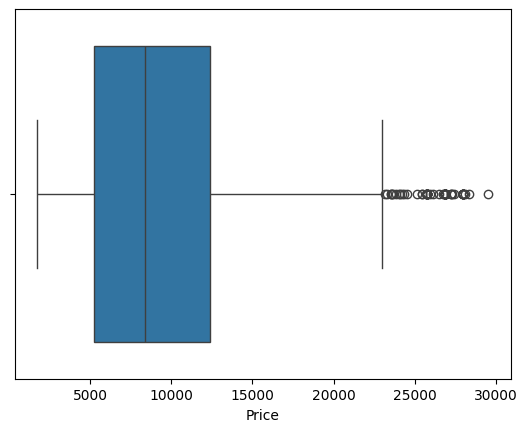

In [ ]:
sns.boxplot(x= 'Price', data=df);

**Convert date data to datetime**

In [ ]:
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')

**Change depature time to only hour**

In [ ]:
df['Dep_Time'] = df['Dep_Time'].str[:2]

**Change arrival time to only hour**

In [ ]:
df['Arrival_Time'] = df['Arrival_Time'].str[:2]

**Change duration to only hour**

In [ ]:
df['Duration'] = df['Duration'].str[:2]

In [ ]:
df['Duration'] = df['Duration'].str.replace('h', '')

In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22,01,2,non-stop,No info,3897
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05,13,7,2 stops,No info,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09,04,19,2 stops,No info,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18,23,5,1 stop,No info,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16,21,4,1 stop,No info,13302


**Find strange values in Duration**

In [ ]:
df['Duration'].unique()

array(['2', '7', '19', '5', '4', '15', '21', '25', '13', '12', '26', '22',
       '23', '20', '10', '6', '11', '8', '16', '3', '27', '1', '14', '9',
       '18', '17', '24', '30', '28', '29', '37', '34', '38', '35', '36',
       '47', '33', '32', '31', '42', '39', '5m', '41', '40'], dtype=object)

**'5m' which seems to be strange is included. So dropped it.**

In [ ]:
df=df[df['Duration'] != '5m']

**Convert depature time, arrival time and duration to int**

In [ ]:
df['Dep_Time'] = df['Dep_Time'].astype(str).astype(int)
df['Arrival_Time'] = df['Arrival_Time'].astype(str).astype(int)
df['Duration'] = df['Duration'].astype(str).astype(int)

**Add month and day columns**

In [ ]:
df['Month']=df['Date_of_Journey'].dt.month
df['Day']=df['Date_of_Journey'].dt.day

**Convert total stop to int**

In [ ]:
df['Total_Stops'] = df['Total_Stops'].str[:1]

In [ ]:
df['Total_Stops'].unique()

array(['n', '2', '1', '3', nan, '4'], dtype=object)

In [ ]:
df['Total_Stops'] = df['Total_Stops'].str.replace('n', '0')

In [ ]:
df=df.dropna(how='any')

In [ ]:
df['Total_Stops'] = df['Total_Stops'].astype(str).astype(int)

**How many different routes are there in data set?**

In [ ]:
df['Route'].nunique()

128

In [ ]:
df['Route'].unique()

array(['BLR → DEL', 'CCU → IXR → BBI → BLR', 'DEL → LKO → BOM → COK',
       'CCU → NAG → BLR', 'BLR → NAG → DEL', 'CCU → BLR',
       'BLR → BOM → DEL', 'DEL → BOM → COK', 'DEL → BLR → COK',
       'MAA → CCU', 'CCU → BOM → BLR', 'DEL → AMD → BOM → COK',
       'DEL → PNQ → COK', 'DEL → CCU → BOM → COK', 'BLR → COK → DEL',
       'DEL → IDR → BOM → COK', 'DEL → LKO → COK',
       'CCU → GAU → DEL → BLR', 'DEL → NAG → BOM → COK',
       'CCU → MAA → BLR', 'DEL → HYD → COK', 'CCU → HYD → BLR',
       'DEL → COK', 'CCU → DEL → BLR', 'BLR → BOM → AMD → DEL',
       'BOM → DEL → HYD', 'DEL → MAA → COK', 'BOM → HYD',
       'DEL → BHO → BOM → COK', 'DEL → JAI → BOM → COK',
       'DEL → ATQ → BOM → COK', 'DEL → JDH → BOM → COK',
       'CCU → BBI → BOM → BLR', 'BLR → MAA → DEL',
       'DEL → GOI → BOM → COK', 'DEL → BDQ → BOM → COK',
       'CCU → JAI → BOM → BLR', 'CCU → BBI → BLR', 'BLR → HYD → DEL',
       'DEL → TRV → COK', 'CCU → IXR → DEL → BLR',
       'DEL → IXU → BOM → COK', 'CCU 

**How many additional info are there in data set?**

In [ ]:
df['Additional_Info'].nunique()

10

In [ ]:
df['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [ ]:
df['Additional_Info'] = df['Additional_Info'].str.replace('No info', 'No Info')

# Visualization

**Price displot by airline**

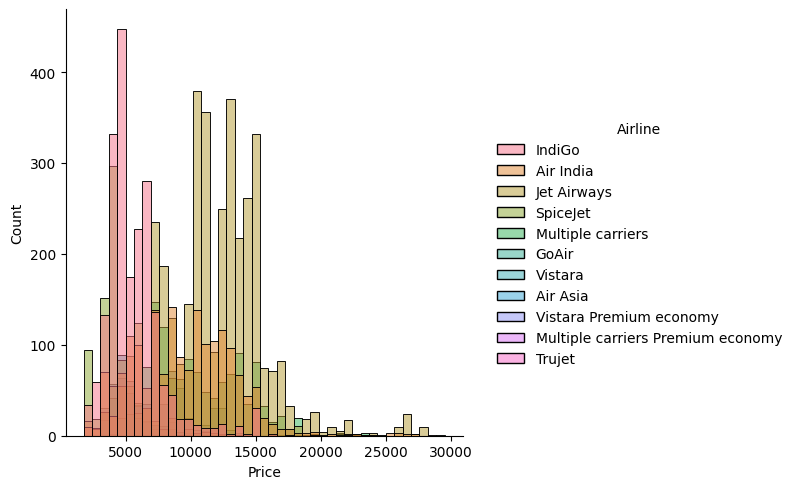

In [ ]:
sns.displot(x= 'Price', data=df,hue='Airline');

**Price displot by source**

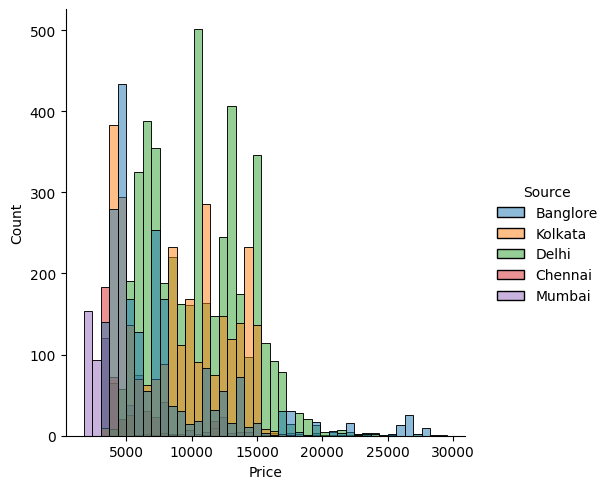

In [ ]:
sns.displot(x= 'Price', data=df,hue='Source');

**Price displot by destination**

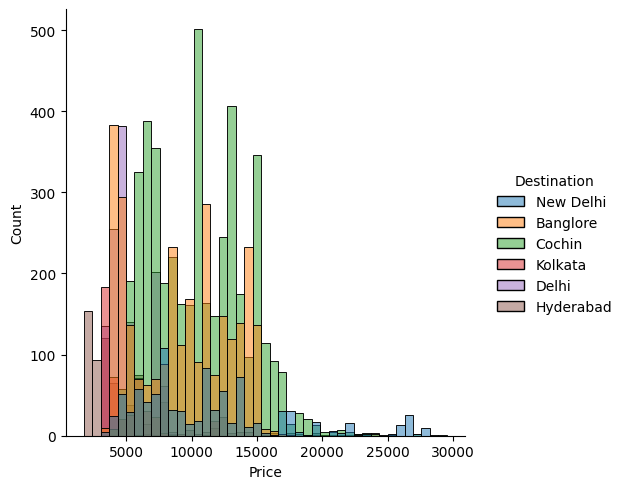

In [ ]:
sns.displot(x= 'Price', data=df,hue='Destination');

**Boxplot by depature time and price**

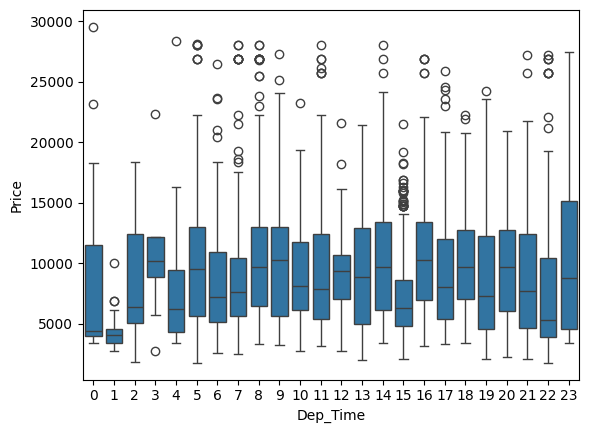

In [ ]:
sns.boxplot(x= 'Dep_Time',y='Price',data=df);

**Boxplot by arrival time and price**

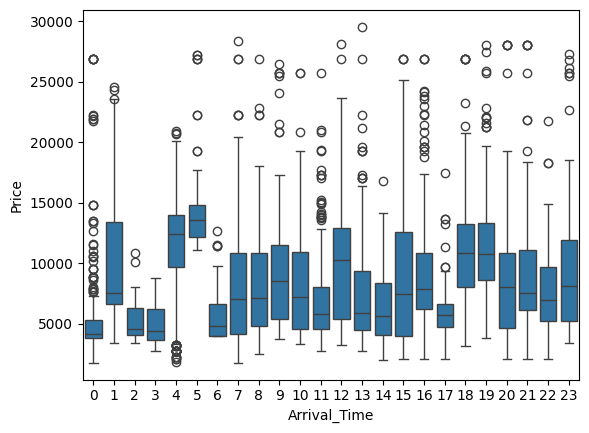

In [ ]:
sns.boxplot(x= 'Arrival_Time',y='Price',data=df);

# Modeling

**Drop columns which are unnecessary or too much and complicated**

In [ ]:
df1=df.drop(['Date_of_Journey','Route'],axis=1)

**Convert categorical variable into dummy/indicator variables**

In [ ]:
df1=pd.get_dummies(df1)

In [ ]:
df1.head()

,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Month,Day,Airline_Air Asia,Airline_Air India,Airline_GoAir,...,Destination_New Delhi,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_Red-eye flight
0,22,1,2,0,3897,3,24,False,False,False,...,True,False,False,False,False,False,False,True,False,False
1,5,13,7,2,7662,5,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,9,4,19,2,13882,6,9,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,18,23,5,1,6218,5,12,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,16,21,4,1,13302,3,1,False,False,False,...,True,False,False,False,False,False,False,True,False,False


**Create explanatory variables X and objective variable y**

In [ ]:
X=df1.drop('Price',axis=1)
y=df1['Price']

**Create train and test data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [ ]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

**Modeling by catboost**

In [ ]:
model = cb.CatBoostRegressor()

In [ ]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

Streaming output truncated to the last 5000 lines.
156:	learn: 1768.0967048	test: 1710.1767532	best: 1710.1767532 (156)	total: 324ms	remaining: 88.8ms
157:	learn: 1765.6235433	test: 1708.3792057	best: 1708.3792057 (157)	total: 328ms	remaining: 87.1ms
158:	learn: 1763.2669491	test: 1706.6268864	best: 1706.6268864 (158)	total: 330ms	remaining: 85ms
159:	learn: 1761.0211375	test: 1704.2720331	best: 1704.2720331 (159)	total: 331ms	remaining: 82.8ms
160:	learn: 1759.3812390	test: 1703.2563802	best: 1703.2563802 (160)	total: 333ms	remaining: 80.7ms
161:	learn: 1756.4111053	test: 1700.2916258	best: 1700.2916258 (161)	total: 335ms	remaining: 78.5ms
162:	learn: 1754.2059553	test: 1698.5611428	best: 1698.5611428 (162)	total: 337ms	remaining: 76.4ms
163:	learn: 1752.2987449	test: 1697.3314938	best: 1697.3314938 (163)	total: 339ms	remaining: 74.4ms
164:	learn: 1750.1041255	test: 1694.4983121	best: 1694.4983121 (164)	total: 341ms	remaining: 72.3ms
165:	learn: 1747.2100534	test: 1692.0446898	best: 1

{'params': {'depth': 8,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [ ]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 1318.58
R2: 0.91


**R2 is 0.91**

# Features importance

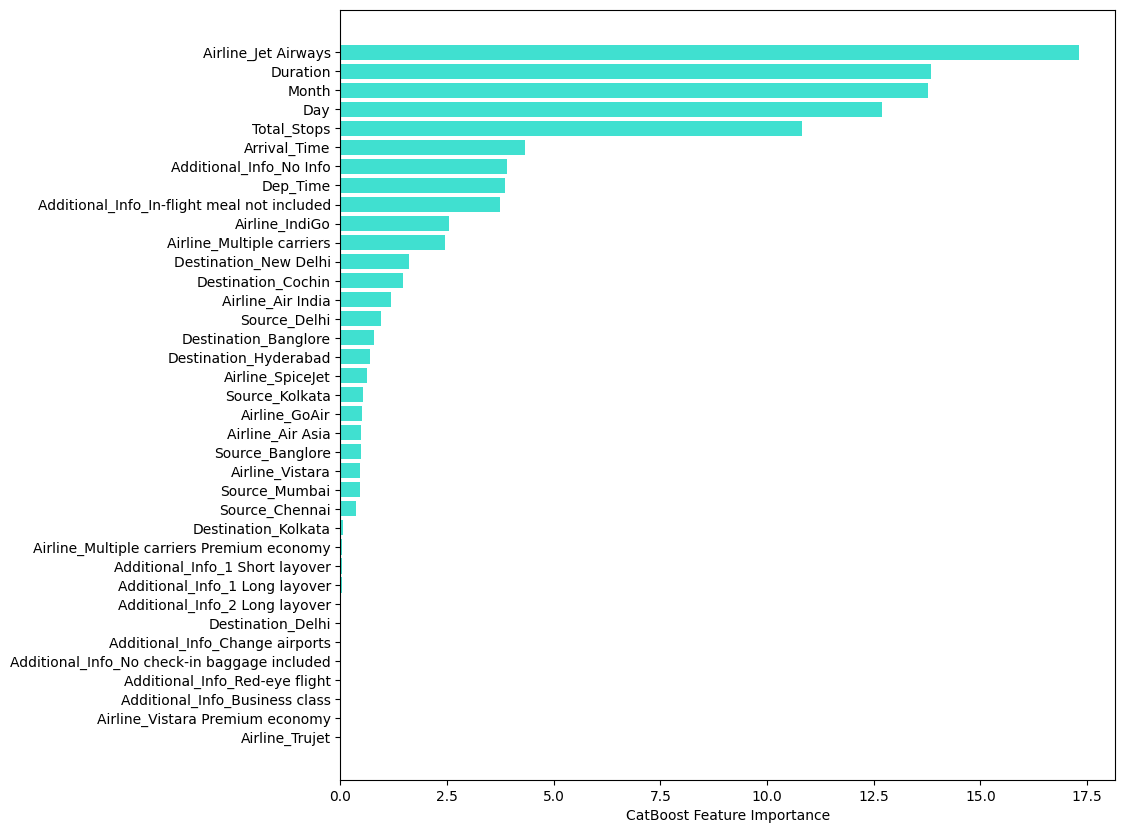

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(X_test.columns[sorted_feature_importance],
        model.feature_importances_[sorted_feature_importance],
        color='turquoise')
plt.xlabel("CatBoost Feature Importance");

**In the features importance, duration, month, day and total stops occupy rank 2nd to 5th. They are internal factors.**

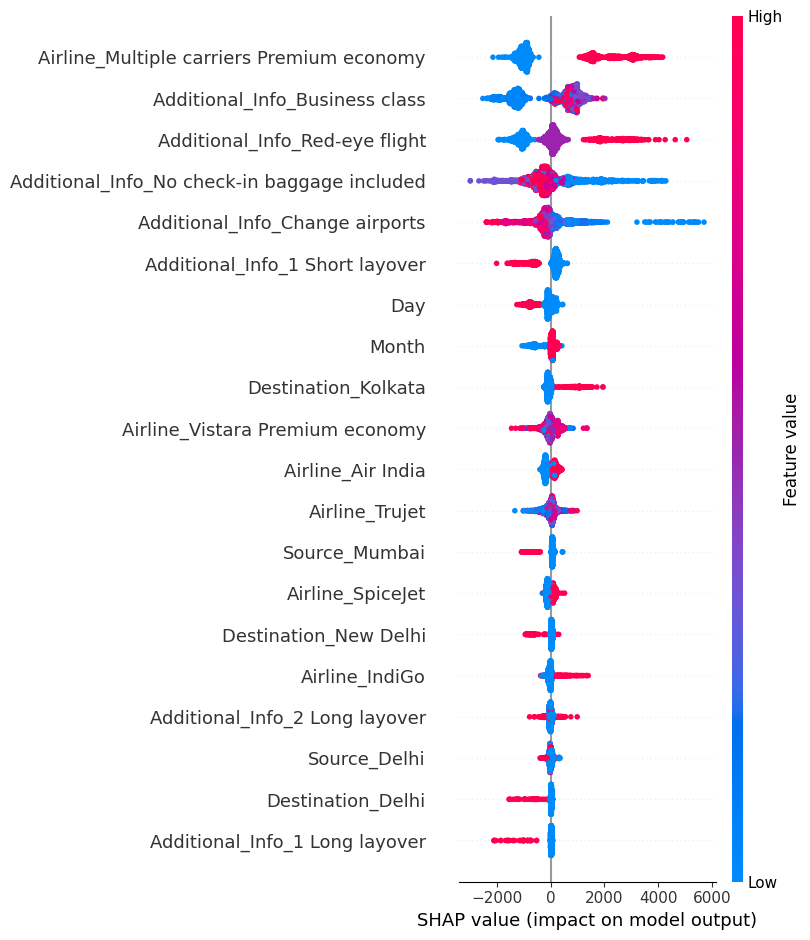

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = X_test.columns[sorted_feature_importance])

**Thank you!**